In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pickle as pkl
from sklearn.model_selection import train_test_split


from tf_logging import TF_LOGGING
from cnn_lstm import CNN_LSTM


tf_logging = TF_LOGGING()
cnn_lstm = CNN_LSTM().create_model()
cnn_lstm.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 12, 1)]           0         
                                                                 
 Conv1 (Conv1D)              (None, 12, 128)           256       
                                                                 
 Conv2 (Conv1D)              (None, 12, 128)           16512     
                                                                 
 MaxPool (MaxPooling1D)      (None, 6, 128)            0         
                                                                 
 LSTM1 (LSTM)                (None, 128)               131584    
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 FC (Dense)                  (None, 1)                 129   

## Loading Data

In [2]:
#Load the data
with open('X.pkl', 'rb') as f:
    X = pkl.load(f)
with open('Y.pkl', 'rb') as f:
    Y = pkl.load(f)

#Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

#Split into training, testing, and validation sets using scikit-learn
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True)

#Print the shapes and types of the data
print('X_train shape:', X_train.shape, 'type:', type(X_train))
print('Y_train shape:', Y_train.shape, 'type:', type(Y_train))
print('X_test shape:', X_test.shape, 'type:', type(X_test))
print('Y_test shape:', Y_test.shape, 'type:', type(Y_test))
print('X_val shape:', X_val.shape, 'type:', type(X_val))
print('Y_val shape:', Y_val.shape, 'type:', type(Y_val))

val_performance = {}
performance = {}

X_train shape: (310194, 12) type: <class 'numpy.ndarray'>
Y_train shape: (310194,) type: <class 'numpy.ndarray'>
X_test shape: (96936, 12) type: <class 'numpy.ndarray'>
Y_test shape: (96936,) type: <class 'numpy.ndarray'>
X_val shape: (77549, 12) type: <class 'numpy.ndarray'>
Y_val shape: (77549,) type: <class 'numpy.ndarray'>


In [3]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.01)
cnn_lstm.compile(loss='mse', optimizer=Adam, metrics=[tf.keras.metrics.RootMeanSquaredError()])

callback = tf_logging.create("logs/cnn_lstm")

cnn_lstm.fit(X_train,Y_train,epochs=10, validation_data=(X_val,Y_val), callbacks=callback)


# loss, accuracy = cnn_lstm.evaluate(X_test,Y_test)


# print(loss, accuracy)

Epoch 1/10
9694/9694 [==============================] - 58s 6ms/step - loss: 0.0394 - root_mean_squared_error: 0.1985 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1939
Epoch 2/10
 218/9694 [..............................] - ETA: 52s - loss: 0.0397 - root_mean_squared_error: 0.1992

KeyboardInterrupt: 

## Plotting Function

In [20]:
def plot(inputs, labels, model=None, max_subplots=3):
  plt.figure(figsize=(12, 8))
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'Energy Generation [normed]')
    plt.plot(inputs[n],
             label='Inputs', marker='.', zorder=-10)

    plt.scatter(x=len(inputs[n]), y=labels[n],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      prediction = model(np.reshape(inputs[n],(-1,12,1)))

      print(inputs[n])
      print(prediction)
      plt.scatter(x=len(inputs[n]), y=prediction,
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [Months]')

## Baseline Model

Just guess that the next data point is the same as the last data point.

In [31]:
class Baseline(tf.keras.Model):
  def __init__(self):
    super().__init__()

  def call(self, inputs):
    return np.reshape(inputs[-1],(-1,1,1))

In [32]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

val_performance = {}
performance = {}


performance['Baseline'] = baseline.evaluate(X_test, Y_test, verbose=1,batch_size=1)
val_performance['Baseline'] = baseline.evaluate(X_val, Y_val,verbose=1, batch_size=1)


performance

NotImplementedError: in user code:

    File "c:\Users\gabes\anaconda3\envs\deeplearning\Lib\site-packages\keras\engine\training.py", line 1852, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\gabes\anaconda3\envs\deeplearning\Lib\site-packages\keras\engine\training.py", line 1836, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\gabes\anaconda3\envs\deeplearning\Lib\site-packages\keras\engine\training.py", line 1824, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\gabes\anaconda3\envs\deeplearning\Lib\site-packages\keras\engine\training.py", line 1788, in test_step
        y_pred = self(x, training=False)
    File "c:\Users\gabes\anaconda3\envs\deeplearning\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\gabes\AppData\Local\Temp\__autograph_generated_file9p17j6rg.py", line 15, in tf__call
        raise
    File "<__array_function__ internals>", line 200, in reshape
        
    File "c:\Users\gabes\anaconda3\envs\deeplearning\Lib\site-packages\numpy\core\fromnumeric.py", line 298, in reshape
        return _wrapfunc(a, 'reshape', newshape, order=order)
    File "c:\Users\gabes\anaconda3\envs\deeplearning\Lib\site-packages\numpy\core\fromnumeric.py", line 54, in _wrapfunc
        return _wrapit(obj, method, *args, **kwds)
    File "c:\Users\gabes\anaconda3\envs\deeplearning\Lib\site-packages\numpy\core\fromnumeric.py", line 43, in _wrapit
        result = getattr(asarray(obj), method)(*args, **kwds)

    NotImplementedError: Exception encountered when calling layer 'baseline_3' (type Baseline).
    
    in user code:
    
        File "C:\Users\gabes\AppData\Local\Temp\ipykernel_20252\2991119083.py", line 6, in call  *
            return np.reshape(inputs[-1],(-1,1,1))
        File "<__array_function__ internals>", line 200, in reshape  **
            
        File "c:\Users\gabes\anaconda3\envs\deeplearning\Lib\site-packages\numpy\core\fromnumeric.py", line 298, in reshape
            return _wrapfunc(a, 'reshape', newshape, order=order)
        File "c:\Users\gabes\anaconda3\envs\deeplearning\Lib\site-packages\numpy\core\fromnumeric.py", line 54, in _wrapfunc
            return _wrapit(obj, method, *args, **kwds)
        File "c:\Users\gabes\anaconda3\envs\deeplearning\Lib\site-packages\numpy\core\fromnumeric.py", line 43, in _wrapit
            result = getattr(asarray(obj), method)(*args, **kwds)
    
        NotImplementedError: Cannot convert a symbolic tf.Tensor (baseline_3/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.
    
    
    Call arguments received by layer 'baseline_3' (type Baseline):
      • inputs=tf.Tensor(shape=(1, 12), dtype=float32)


[0.49659652 0.56263093 0.4661365  0.35725687 0.56349885 0.28323169
 0.28366066 0.15063747 0.35619443 0.43721111 0.52000352 0.52409368]
tf.Tensor(
[[0.49659652]
 [0.56263095]
 [0.4661365 ]
 [0.35725686]
 [0.56349885]
 [0.28323168]
 [0.28366065]
 [0.15063746]
 [0.35619444]
 [0.43721113]
 [0.5200035 ]
 [0.5240937 ]], shape=(12, 1), dtype=float32)


ValueError: x and y must be the same size

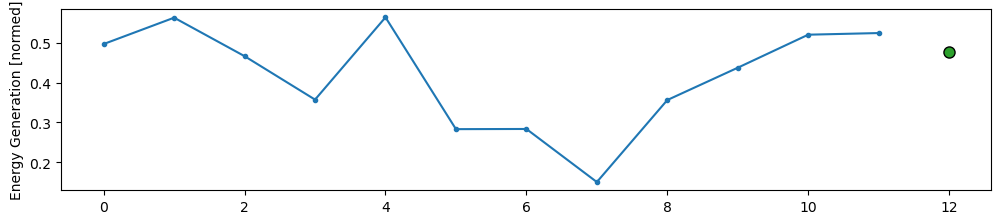

In [29]:
plot(inputs=X_val, labels=Y_val, model=baseline)

[0.49659652 0.56263093 0.4661365  0.35725687 0.56349885 0.28323169
 0.28366066 0.15063747 0.35619443 0.43721111 0.52000352 0.52409368]
tf.Tensor([[0.49226442]], shape=(1, 1), dtype=float32)
[0.91147298 0.94433753 0.97246484 0.79200592 0.9626943  0.69015544
 0.67150259 0.85373797 0.87017024 0.87772021 0.77113249 0.92361214]
tf.Tensor([[0.79195446]], shape=(1, 1), dtype=float32)
[0.82127707 0.80587185 0.83657066 0.82473766 0.8659299  0.94965394
 0.76546104 0.8917169  0.86213441 0.95356106 0.78700603 0.78220585]
tf.Tensor([[0.7252587]], shape=(1, 1), dtype=float32)


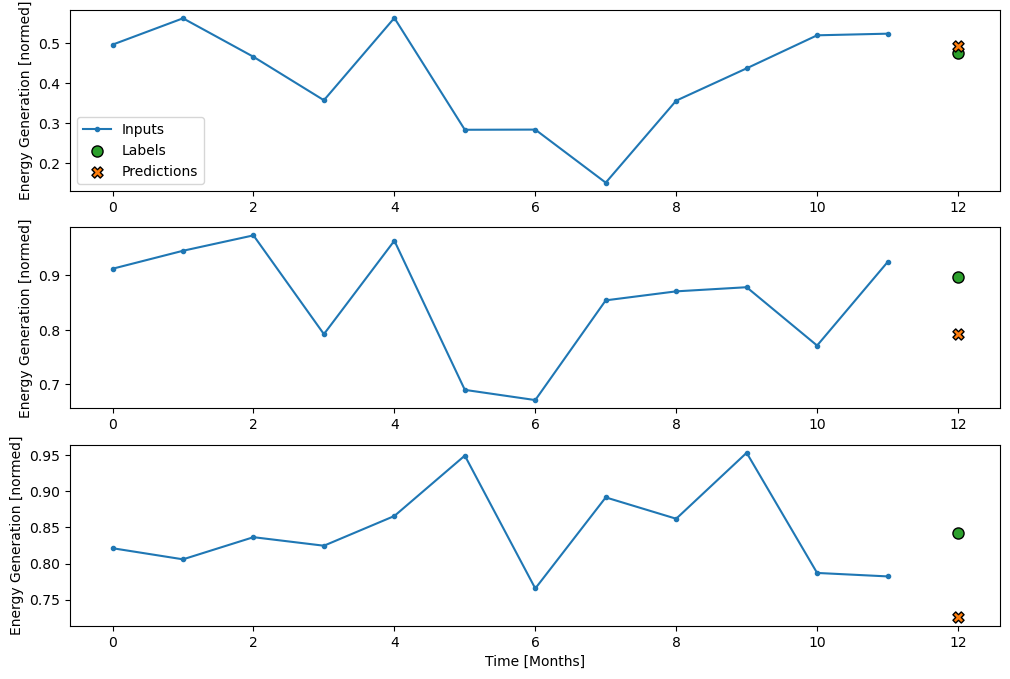

In [21]:
plot(inputs=X_val, labels=Y_val, model=cnn_lstm)

In [6]:
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
%tensorboard --logdir logs